# Introduction - Let me tell you about a guy named Stan...

In [38]:
from IPython.display import Image
Image(url='https://upload.wikimedia.org/wikipedia/commons/8/8a/STAN_ULAM_HOLDING_THE_FERMIAC.jpg')

Picture of Stan Ulam - One of the pioneers of Bayesian analysis - he built Bayesian models to understand particle interactions that led to the successful implementation of the atomic bomb

# The Bayesian Approach to the Simple Linear Model (SLR) and Multi-Linear Regression (MLR)

So although the basic idea of Bayesian regressions is not much different from what you saw when doing linear regressions. There will be a major difference in how they are implemented in code. Whereas one simply pushed in columns of data and a target into a regression to get output, the actual "specification" of the model is a bit more involved in the Bayesian variety. In particular, you will have to specify priors, likelihoods etc. However, fear not, we are not going to write any of these posterior distributions and their associated ingredients manually. We're going to introduce a dedicated software packages this week, PyStan, that not only gives you leverage in the specification side, but includes a whole lot of really efficient C++ code to do the parameter estimation. Unlike what you did earlier in the week, we won't use MLE to estimate the parameters utilizing the Monte-Carlo Markov Chain (MCMC). 

Although this topic is in itself not the point of our lecture, it will be a tool we leverage over-and-over again to estimate our models. For those of you who are interested in reading more, check out the following link: 

- Hardcore primer (requires Calculus, and strong mathematical maturity: http://www4.stat.ncsu.edu/~sghosh/TEACHING/st790/lectures/GillMCMC.pdf
- Not as Hardcore: http://statwww.epfl.ch/teaching/3eCycleRomand/printemps-2005/EG.lectures.villars05.pdf

Sorry, there's just no way around a lot of mathematics when dealing with MCMC. 


# Bayesian Regression vs Classical Regressions


Getting back to our previous discussion, the difference between classical and Bayesian regression can be thought of as thus: 
-   Classical regression is a special case of the Bayesian perspective whereby we have a non-informative prior. 

I'm sure you recall what 'non-informative' refers to uniform priors (i.e. no prior information assumed to bias things one way or another). 

The Bayesian approach also relaxes a few assumptions, we no longer have to assume homoscedasticity etc. 

(Just in case you need to review this homoskedasticity: https://www.youtube.com/watch?v=zRklTsY9w9c).

You can remember what it means by just breaking the word down to it's component parts - homo : same, skedastic : variation, the later word can be thought of as being related to "skew" i.e. how much your line "skews" from the "true" trend-line.

However, as previously stated, the Bayesian approach is fundamentally the "inverse" trick (i.e f(X|$\theta$) to f($\theta$|X)), and is primarily concerned with estimating parameters. In the case of Regressions, estimating $\beta$'s and estimating $\sigma$'s (and thus $\sigma^2$'s).

Why does this matter? Bayesian regressions give you, the modeler/data scientist a lot more control over your model. You can specify priors for each of the parameters in your regression (the $\beta$'s), the error term, and even the constant (as well as the target). Therefore, it's worth to learn, and will give you more latitude to fit your model to the data you 

So we know that the joint of $\beta$ and $\sigma^2$ is proportional to the precision, defined as $\frac{1}{\sigma^2}$. Further, $$p(\beta, \sigma^2|{y}) = p(\beta|{y}, \sigma^2)p(\sigma^2|{y})$$

As we mentioned previously, we have check that this is not a pathological probability (proper) blah blah, but this ins't a mathematics course, so we'll again be blissfully ignorant of these complexities. 

If we had a procedural step-wise perspective of the procedure, here's what it would be: 

1. Determine $\beta$, $\sigma$ using posterior distributions
2. Construct $y_{i+1}, y_{i+2}, ... y_{i+n}$ from a distribution using the parameters from step 1

# Introduction to PyStan

The most critical element of the PyStan interface is the model specification module. This is also possibly the most tricky, since it's going to be passed in as a bulk-string from Python's perspective, any snytax issues won't immediately be caught by an error-checking feature from your IDE.

So what's going on? Basically to get PyStan to work, you need to pass a string (from Python's perspective, into the PyStan library, which than "hits" the C++ compiler, which then interprets yours string as actual code in C++. The computation is executed (within C++), and then the results are passed back to you. It's sort of like working with an API, but everything is internal to your machine. I've created a simple diagram to explain what's going on below.




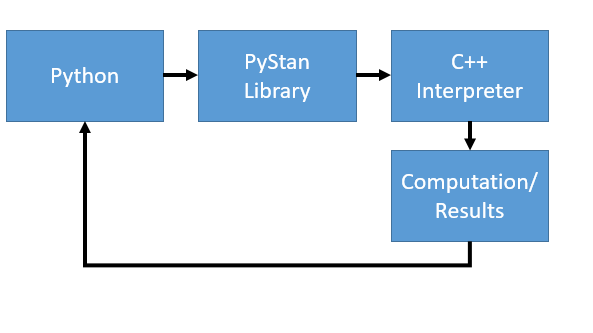

In [39]:
Image('../assets/images/PyStan Diagram.PNG')


But, the we all got to remove the training wheels at some point! (at some point in your career you'll end up mareling your co-workers by writing script directly to notepad or wordpad(+) )

I've provided a template of how PyStan model code should be pushed into the PyStan library. Note, that 

In [40]:
# This is a critical string that we need to pass from our main interface (Python) to the Stan interpretor 
'''
data {
// Defining your data 
}
transformed data{}

parameters {
// Defining the name of your parameter and it's numerical parameters
// Explicitly required 
}

transformed parameters{}

model {
// Specifying your model parameters
// Explicitly required
}

generated quantities{}
'''

"\ndata {\n// Defining your data \n}\ntransformed data{}\n\nparameters {\n// Defining the name of your parameter and it's numerical parameters\n// Explicitly required \n}\n\ntransformed parameters{}\n\nmodel {\n// Specifying your model parameters\n// Explicitly required\n}\n\ngenerated quantities{}\n"

# Description of components 

#### Data component (Optional)

This is where you will define your major parameters and targets (variables or columns in data-speak), so if you have a regression equation, you need to define the target/dependent variable ('y') and the feature/independent/predictor variables (why are there so many different words that describe the same thing?) 

In the process of defining the variables, you will need also define where the variable ranges and it's type (for those of you who have coded before in C++ or Java, this will be familiar to you). Lastly, each line needs to end with a semi-colon. If you haven't guessed it, you're basically sending small snippets of C-code into the Stan interface from Python!

#### Transformed Data Component (Optional)

This is as it sounds, it's basically any data that can be derived from other data (think sample means, standard errors etc.) 

#### Parameters Component 

This is where you will define any population parameters to do Bayesian inference on, these can include mean, medians, variance etc., like the data  component, you need also specify the range and the type of the listed parameters

#### Transformed Parameters Component (Optional)

This is where you deposit any transformed parameters, think log-transform. Of course, you won't have to specify the range or type of the variables since you're merely transforming parameters (variables/columns) you've already defined in the data component of the structure

#### Model Component 

This is where you will specify your model, so in the context of Bayesian computation/inference you will have to define your priors, likelihood etc. Unlike the above, you will not specify ranges of these models, you will however use the ~ symbol (tilde) as the assignment symbol.

#### Generated Quantities Component (Optional)

This is the "everything else" category, any parameters or data that do not share a direct functional relationship with the estimation process. 

#### Simple Example of a single paramter Bayesian inference

Let's now take a look at a simple C-code snippet for Stan model definition. Notice we're using a bulk string ''' stuff ''' format here to pass multi-line strings into PyStan. Also note the way the PyStan string is written with semi-colons after each line, this is basically C++ syntax. 

Look above at the description of each component and what's written in the code box below. Once you understand how/why everything is where it is, please move forward. If you need more details (or just curious), check out the PyStan docs. 

In [41]:

# data {
# int<lower=0> n; 
# int<lower=0, upper=1> y[n]; 
# }
# parameters {
# real<lower=0, upper=1> theta; 
# }
# model {
# theta ~ beta(1, 1); 
# y ~ bernoulli(theta); 
# }
# '''

# Practicing Model Specification in Stan

#### 1.1 Coin toss with Stan

Like previously, we go from the bernoulli scheme to the binomial

In [42]:
'Note - this is a lab answer'


data {
    int<lower=0> n; 
    int<lower=0> heads; 
}
parameters {
    real<lower=0, upper=1> param;
}
model {
    param ~ beta(2, 2);
    heads ~ binomial(n, param);
}

'''

SyntaxError: invalid syntax (<ipython-input-42-8b6cb96cb472>, line 4)

#### Problem 1 :  Bayesian SLR for 1 Parameter with Stan

Write a Stan model for a SLR, using the simple example given and the previous exercise as a template 

In [ ]:
'Note - this is the lab answer '


data {
 int<lower = 0> n; // number of observations
 real y[n]; // response variable
 real x[n]; // predictor variable
}

parameters {
// Remember from high school y = ax + b
 real a; real b; 
 real<lower=0> sd; // standard deviation
}

transformed parameters {
 real target[n]; 
 
for(i in 1:n)
 target[i] <- a*x[i] + b;
}

model {
 y ~ normal(mu, sd);
}

'''

# The Boston Housing Market Data Set

#### Problem 2 - Loading Data and running a STAN model

Today we're going to be studying a standard UCI Machine Learning data (an oldie but a goodie as they say), https://archive.ics.uci.edu/ml/datasets/Housing

The data contains information that are possibly related to housing values in the Boston suburb (think Zip Realty -maybe not). Here's a brief summary of the data found on the website: 

    - CRIM      per capita crime rate by town
    - ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    - INDUS     proportion of non-retail business acres per town
    - CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    - NOX       nitric oxides concentration (parts per 10 million)
    - RM        average number of rooms per dwelling
    - AGE       proportion of owner-occupied units built prior to 1940
    - DIS       weighted distances to five Boston employment centres
    - RAD       index of accessibility to radial highways
    - TAX       full-value property-tax rate per 10,000 USD
    - PTRATIO   pupil-teacher ratio by town
    - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
    - LSTAT    % lower status of the population
    - MEDV     Median value of owner-occupied homes in 1000 USDs


Load the data and list the first 5 observations to get a feel for the data

In [43]:
from __future__ import division
import pystan
import os
import pylab as py
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

# Load the data

housing = pd.read_csv('../assets/datasets/housing.csv')
housing.head(5)

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Create a dictionary with the target (dependent variable), the feature, (dependent variable), and the size of data (the row number)

In [44]:
# Build a dictionary for Stan model processing
dat = {'n': len(housing), 'x': [housing.CRIM, 'y': housing.MEDV}


Create a bivariate plot for the target and feature

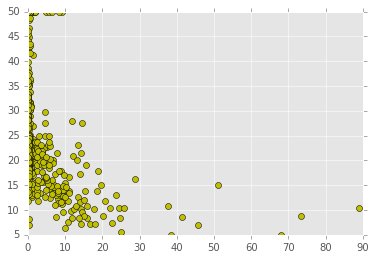

In [45]:
# Output the data to get a view of 

py.plot(housing.CRIM, housing.MEDV, 'yo')
py.show()

Construct the STAN model

In [46]:
# Load the STAN model 

reg_model = '''data {
    int<lower=0> n;
    real x[n];
    real y[n];
}
parameters {
    real a;
    real b;
    real sigma;
}
transformed parameters {
    real mu[n];
    for (i in 1:n) {
        mu[i] <- a*x[i] + b;
        }
}
model {
    sigma ~ uniform(0, 20);  //Remember step 1?
    y ~ normal(mu, sigma); // Remember step 2?
}

'''

#### Bonus Exercise 

A brief detour bonus exercise - Vectorize the regression model in STAN

In [47]:
# # Note - This is a lab answer
# # Vectorize the reg model in STAN

# vectorize_reg =
# data {
#     int<lower=0> n;
#     int<lower=0> m;
#     matrix[n, m] x;
#     vector[n] y;
# }
# transformed data {
#     vector[n] cons;
#     matrix[n, m+1] x;

#     cons <- rep_vector(1, n);
#     x <- append_col(cons, xi);
# }
# parameters {
#     vector[k] beta;
#     real<lower=0> sigma;
# }
# model {
#     y ~ normal(xi * beta, sigma);
# }


Now back to the original exercise, initialize your Stan model in PySTan 

In [48]:
model = pystan.stan(model_code = reg_model, n_jobs = -1, data = dat, chains=1) 

# Remember n_jobs = 1 is for Windows user 


We're going to build our first trace plot. What's a trace plot? It's a diagnostic tool to understand how well our "mixing" is occuring while implementing the MCMC estimation. In general we want our traceplots to be devoid of 'jump' (see picture below - thanks Harvard: http://www.people.fas.harvard.edu/~plam/teaching/methods/convergence/convergence_print.pdf)



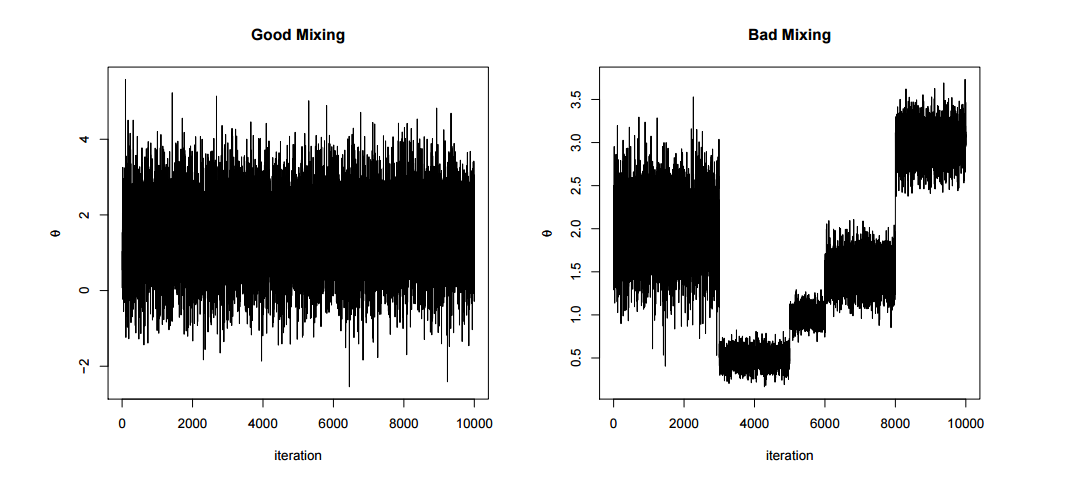

In [49]:
Image('../assets/images/traceplot examples.PNG')

Make a trace plot for the estimated parameter, using histogram, and **NOT** the traceplot method in PyStan. Please read through the docs and look up the .extract() method. Remember, do things the hard way first, then we can do it the easy way. 

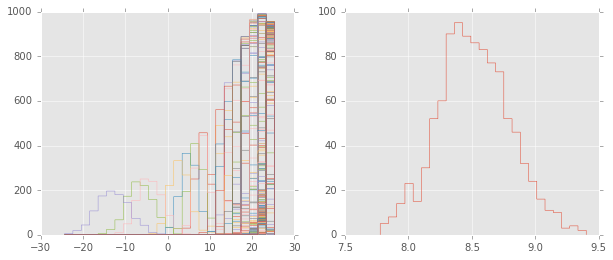

In [50]:
# Visualize the mean, and variance convergence using matplotlib

trace = model.extract()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1);
plt.hist(trace['mu'][:], 25, histtype='step');
plt.subplot(1,2,2);

plt.hist(trace['sigma'][:], 25, histtype='step');

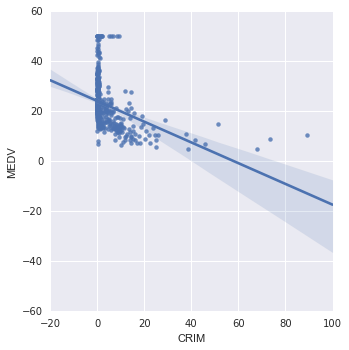

In [51]:
import seaborn as sns
sns.lmplot('CRIM', 'MEDV', housing)

In [52]:
from sklearn import linear_model

mod = linear_model.LinearRegression()
mod.fit(housing.AGE, housing.MEDV)

/Users/jb3/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found arrays with inconsistent numbers of samples: [  1 506]

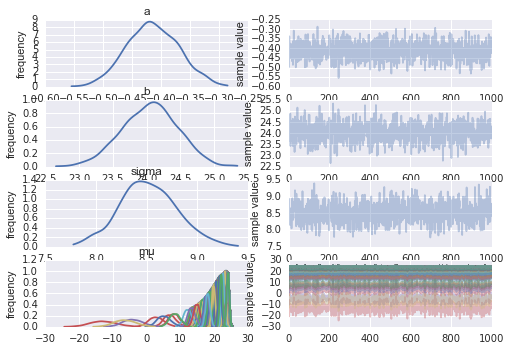

In [53]:
# Use the traceplot method from pystan to output the graph ... much easier than constructing from a histogram don't you think? 

model.traceplot()
py.show()

In [54]:
#Print your model here

print(model)


Inference for Stan model: anon_model_dc26c21336dc6f0bf0e81cccf9d32d52.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        -0.41  2.4e-3   0.04   -0.5  -0.45  -0.42  -0.38  -0.33  334.0    1.0
b        24.05    0.02   0.41  23.23  23.77  24.06  24.32  24.84  327.0    1.0
sigma     8.52    0.02   0.28   7.97   8.33   8.51    8.7   9.11  334.0    1.0
mu[0]    24.05    0.02   0.41  23.23  23.77  24.06  24.32  24.84  327.0    1.0
mu[1]    24.04    0.02   0.41  23.22  23.76  24.05  24.31  24.83  327.0    1.0
mu[2]    24.04    0.02   0.41  23.22  23.76  24.05  24.31  24.83  327.0    1.0
mu[3]    24.04    0.02   0.41  23.21  23.76  24.05  24.31  24.83  327.0    1.0
mu[4]    24.02    0.02   0.41   23.2  23.74  24.03  24.29  24.81  327.0    1.0
mu[5]    24.04    0.02   0.41  23.22  23.76  24.05  24.31  24.83  327.0    1.0
mu[6]    24.01    0.0

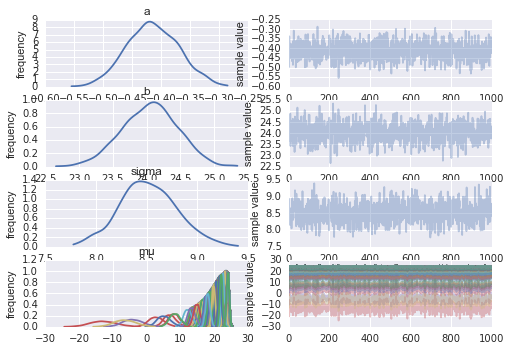

In [55]:
model.plot()
plt.show()